<a href="https://colab.research.google.com/github/ugurtegin/Nonlinear_MMF_Network/blob/main/Simulations/BPM_SpokenDigit_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Most general audiodigit single layer back end

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Activation, LSTM
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D 
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical, normalize
import hub
import seaborn as sns
import pandas as pd
import cv2
# Load the Drive helper and mount
#from google.colab import drive

# This will prompt for authorization.
#drive.mount('/content/drive')

/Users/mcroning/miniforge3/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.0.17) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [3]:
!cd '/Users/mcroning/Anaconda'
filepath="/Users/mcroning/Anaconda/"

In [4]:
ds = hub.load("hub://activeloop/spoken_mnist")

hub://activeloop/spoken_mnist loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist


In [5]:
out_sp_str=np.squeeze(ds.speakers.numpy())
out_labels=np.squeeze(ds.labels.numpy())

In [6]:
cats_sp, out_sp = np.unique(out_sp_str, return_inverse=True)
cats_lb, out_lb = np.unique(out_labels, return_inverse=True)

In [7]:
num_labels=np.size(np.unique(cats_lb))
num_speakers=np.size(np.unique(cats_sp))

In [8]:
ugurdata=True
out_class='labels' #out_class 'speakers' or 'labels'

In [9]:


if ugurdata==True:
    f = sio.loadmat(filepath+'/res_sq_digits.mat')
    inp2 = f['res_sq_flt']
    f2 = sio.loadmat(filepath+'/label_digits.mat')
    out = np.squeeze(f2['label'])
    numimages=np.shape(inp2)[0]
    runtype='SOLO paper Fig 3f'
    datasize=int(np.sqrt(np.shape(inp2)[1]))
else:
    #f = np.load(filepath+'audiodigits_glm6.npz');runtype='gain*length -6a'
    f = np.load(filepath+'audiodigit6464.npz');runtype='original_spectrograms'
    inp2a = np.squeeze(f['arr_0'])
    numimages=np.shape(inp2a)[0]
    inp2=np.zeros((numimages,22,22))
    for j in range(numimages): #downsample to be fair
        inp2[j,:]=cv2.resize(inp2a[j],(22,22))   
    datasize=int((np.shape(inp2)[1]))    
    inp2=np.reshape(inp2,(numimages,datasize*datasize))
    out=f['arr_1'][:numimages]

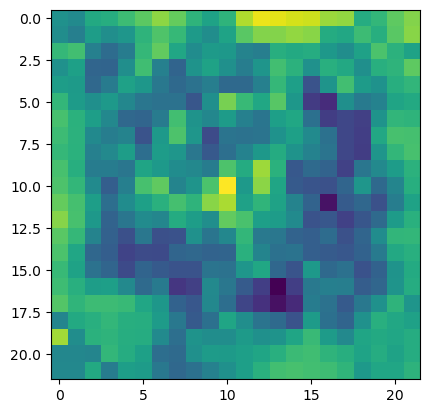

In [13]:
plt.imshow(np.reshape(inp2[2000],(datasize,datasize)))
plt.savefig(filepath+'/typinput'+runtype+'.png')

In [14]:
"""
import scipy.io as sio
f = sio.loadmat(filepath+'New_audio/flattened_longer.mat')
inp2 = f['flattened']

#Load data
f2 = sio.loadmat(filepath+'New_audio/label_digits.mat')

out = np.squeeze(f2['label'])
"""

"\nimport scipy.io as sio\nf = sio.loadmat(filepath+'New_audio/flattened_longer.mat')\ninp2 = f['flattened']\n\n#Load data\nf2 = sio.loadmat(filepath+'New_audio/label_digits.mat')\n\nout = np.squeeze(f2['label'])\n"

In [15]:
input_data = inp2
imp2=(inp2-inp2.min())/(inp2.max()-(inp2.min()))*2-1
if out_class=='speakers':
    num_classes=num_speakers
    output_data = to_categorical(out_sp,num_classes=num_classes) 
    conf_map_labels=cats_sp
elif out_class=='labels':
    num_classes=num_labels
    output_data = to_categorical(out_labels,num_classes=num_classes)
    conf_map_labels=cats_lb
else:
    print('error in class names')
print('input_data : ', input_data.shape, input_data.dtype)
print('output_class : ', output_data.shape, output_data.dtype)
print()

input_data :  (3000, 484) float64
output_class :  (3000, 10) float32



In [16]:
output_data[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [17]:
oran = 0.20
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=oran)

print('Test data : ', X_test.shape, X_test.dtype)
print('Training data : ', X_train.shape, X_train.dtype)
print()

Test data :  (600, 484) float64
Training data :  (2400, 484) float64



In [18]:
inp_dim = np.shape(X_test)[1]

In [19]:
inp_dim

484

In [20]:
model = Sequential()
model.add(Dense(num_classes, input_dim=inp_dim, activation='softmax'))

Metal device set to: Apple M1 Pro


2022-11-10 15:04:20.041818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-10 15:04:20.042104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
loss='categorical_crossentropy' # mean_absolute_error, cosine_proximity
metrics = ['accuracy']  # network accuracy metric to be determined after each epoch, mean_absolute_error, cosine_proximity

opt1 = SGD(lr=0.001, momentum=0.9)
opt2 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=opt2, loss=loss, metrics=metrics)
model.summary()

/Users/mcroning/miniforge3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/Users/mcroning/miniforge3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                4850      
                                                                 
Total params: 4,850
Trainable params: 4,850
Non-trainable params: 0
_________________________________________________________________


In [22]:
#setting final parameters for the network and it begins to train
number_of_iterations = 50
batch_size = 50

#history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=number_of_iterations)
history=model.fit(X_train, y_train, batch_size=batch_size, epochs=number_of_iterations, verbose=1, validation_data=(X_test, y_test))
#Number of iterations run: 900

Epoch 1/50


2022-11-10 15:04:20.318995: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-10 15:04:20.485545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 10ms/step - loss: 2.4135 - accuracy: 0.1646 - val_loss: 2.1756 - val_accuracy: 0.1983
Epoch 2/50
 8/48 [====>.........................] - ETA: 0s - loss: 2.0554 - accuracy: 0.2675

2022-11-10 15:04:20.948378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 0s 8ms/step - loss: 1.9938 - accuracy: 0.2638 - val_loss: 1.9951 - val_accuracy: 0.2333
Epoch 3/50
48/48 [==============================] - 0s 8ms/step - loss: 1.8451 - accuracy: 0.3092 - val_loss: 1.9210 - val_accuracy: 0.2567
Epoch 4/50
48/48 [==============================] - 0s 8ms/step - loss: 1.7586 - accuracy: 0.3187 - val_loss: 1.8663 - val_accuracy: 0.2683
Epoch 5/50
48/48 [==============================] - 0s 8ms/step - loss: 1.6948 - accuracy: 0.3404 - val_loss: 1.8190 - val_accuracy: 0.2767
Epoch 6/50
48/48 [==============================] - 0s 8ms/step - loss: 1.6418 - accuracy: 0.3725 - val_loss: 1.8054 - val_accuracy: 0.2967
Epoch 7/50
48/48 [==============================] - 0s 9ms/step - loss: 1.6020 - accuracy: 0.3838 - val_loss: 1.7532 - val_accuracy: 0.3100
Epoch 8/50
48/48 [==============================] - 0s 9ms/step - loss: 1.5659 - accuracy: 0.3996 - val_loss: 1.7356 - val_accuracy: 0.3050
Epoch 9/50
48/48 [=============

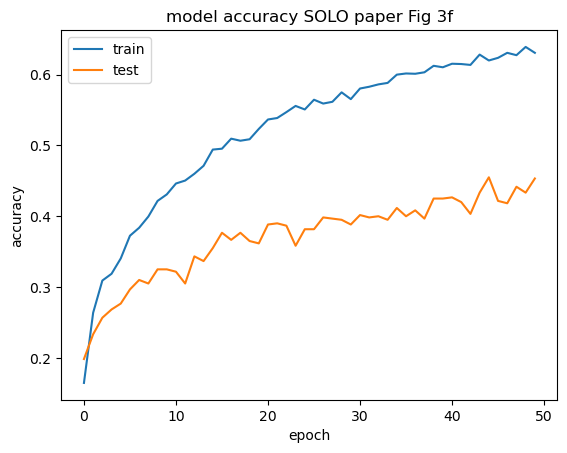

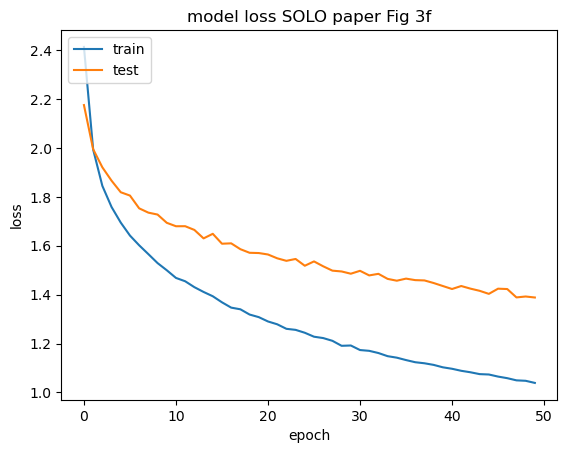

In [23]:
#from google.colab import files
# summarize history for loss

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy '+runtype)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.ylim(0.02,0.4)
plt.savefig(filepath+'/accy_'+runtype+'.png')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss '+runtype)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.ylim(0.02,0.4)
plt.savefig(filepath+'/loss_'+runtype+'.png')
plt.show()

#files.download('loss-1.png')

In [24]:
plt.show()

In [25]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
los=history.history['loss']
val_los=history.history['val_loss']

sio.savemat(filepath+'digitraw_acc_val_acc.mat',{'acc':acc,'val_acc':val_acc})
sio.savemat(filepath+'digitraw_loss_val_loss.mat',{'loss':los,'val_loss':val_los})

19/19 [==============================] - 0s 2ms/step


2022-11-10 15:04:41.128238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


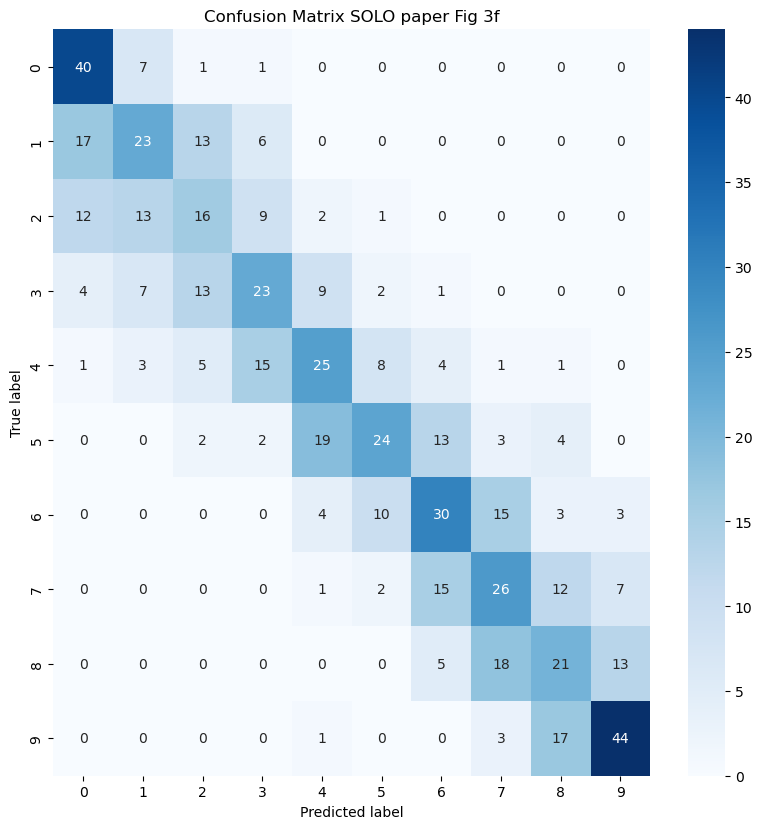

In [26]:
y_pred=model.predict(X_test)
y_pred_max=np.argmax(y_pred,axis=1)
y_test_max=np.argmax(y_test,axis=1)
con_mat = tf.math.confusion_matrix(labels=y_test_max, predictions=y_pred_max).numpy()
df_cm = pd.DataFrame(con_mat, index = [i for i in conf_map_labels],
                  columns = [i for i in conf_map_labels])
figure = plt.figure(figsize=(8, 8))
sns.heatmap(df_cm, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix '+runtype)
plt.savefig(filepath+'/cmat_'+runtype+'.png',bbox_inches='tight')
plt.show()

In [27]:
filepath+'/accy_'+runtype+'.png'

'/Users/mcroning/Anaconda//accy_SOLO paper Fig 3f.png'